# K-Nearest Neighbor Lab





In [66]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from scipy.io import arff
import pandas as pd
import numpy as np
import pdb
import matplotlib.pyplot as plt
import math
import copy

## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [59]:
#var_x = np.random.random((10,3))
#var_y = np.random.random(3)
columntype = ["num", "cat", "num"]
columntype = np.array(columntype)
print(columntype == 'num')
print(var_x[:, columntype == 'num'])
print("new point: ", var_y[columntype == 'num'])
print(np.linalg.norm(var_x - var_y, axis = 1))

print((((.95501394 - .74156679) ** 2) + ((.95501394 - .74156679) ** 2)) ** (1/2))
print(np.linalg.norm(.95501394 - .7415667))
print(np.linalg.norm(.7415667 - .95501394))
#print(columntype)
#print(columntype == 'num')
# print(var_x.shape)
# print(var_y.shape)
# print((var_x - var_y).shape)

# print((np.linalg.norm(var_x - var_y, axis = 1)).shape)



[ True False  True]
[[0.95501394 0.74156679]
 [0.60086886 0.13154574]
 [0.76417164 0.38422258]
 [0.19362365 0.29631588]
 [0.80812269 0.63819761]
 [0.60149244 0.30650241]
 [0.81700964 0.62598268]
 [0.24963625 0.32439719]
 [0.579226   0.43944754]
 [0.97466385 0.09976997]]
new point:  [0.70339385 0.31047124]
[0.56142978 0.20661088 0.27880859 0.62367723 0.64345549 0.53588618
 0.50441689 0.53402136 0.41375018 0.43143117]
0.3018598543798843
0.21344723999999993
0.21344723999999993


In [67]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, output_type = "categorical", columntype=[], weight_type='inverse_distance', normalize = False): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.output_type = output_type
        self.columntype = np.array(columntype) #Note This won't be needed until part 5 'continuous' or 'nominal'
        self.weight_type = weight_type
        self.normalize = normalize
 
        

    def fit(self, data, target_labels, k = 3):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """

        self.k = k
        self.train_data = np.array(data)
        self.target_labels = target_labels
        
        self.train_min = []
        self.train_max = []

        #pdb.set_trace()
        if self.normalize:
            # get mins and maxs for each column
            for i in range(data.shape[1]):
                self.train_min.append(np.amin(data.T[i])) # Get min from col
                self.train_max.append(np.amax(data.T[i])) # Get max from col

            #(x-xmin)/(xmax-xmin) use train data's mins and maxs 
            for i in range(data.shape[0]): # rows
                for j in range(data.shape[1]): # cols
                    if self.columntype[j] == 'numeric':
                        self.train_data[i][j] = np.nan_to_num((self.train_data[i][j] - self.train_min[j]) / (self.train_max[j] - self.train_min[j])) # Normalize all train_data
        
        #pdb.set_trace()
        return self
    
    def run_knn(self, new_point): 
        distances_temp = np.linalg.norm(np.float64(self.train_data[:, self.columntype == 'numeric'] - new_point[self.columntype == 'numeric']), axis = 1)

        # Store indexes for non numeric data types for input
        indexes_to_compare = []
        #pdb.set_trace()

        for i,col in enumerate(self.columntype):
            if col != 'numeric':
                indexes_to_compare.append(i)
        
        #pdb.set_trace()
        # compare categorical values and add 1 dist if they are the same
        for d, row in enumerate(self.train_data):
            for ind in indexes_to_compare:
                if self.train_data[d][ind] != new_point[ind]:
                    #print("[ ", self.train_data[d][ind], " Did not match -> ", new_point[ind], " ]")
                    distances_temp[d] += 1 # Add 1 to distance if categorical col's values DONT match up

        # Create pairs with target label
        distances = []
        for i,dist in enumerate(distances_temp):
            distances.append((dist, self.target_labels[i]))
        
        # Get k nearest neighbors
        distances.sort()
        neighbors = distances[:self.k]        
        #print("Neighbors: ", neighbors)
        # For NUMERICAL outputs
        if self.output_type == 'numeric':
            # Output the mean of the k-nearest neighbors
            values = []
            weights = []

            if self.weight_type == 'no_weight':
                for distance, value in neighbors:
                    values.append(value)

                return np.array(values).mean()

            elif self.weight_type == 'inverse_distance':
                #pdb.set_trace()
                for distance, value in neighbors:
                    w = (1 / distance ** 2) if distance != 0 else 0
                    weights.append(w)
                    values.append(value*w)
                    
            return np.array(values).sum()/np.array(weights).sum() # Divide the sum of the values by the sum of the weights
        else: ## For CATEGORICAL outputs
            if self.weight_type == 'no_weight':
                votes = {}
                for curr_point in neighbors:
                    if curr_point[1] in votes:
                        votes[curr_point[1]] += 1
                    else:
                        votes[curr_point[1]] = 1
            elif self.weight_type == 'inverse_distance':
                votes = {}
                for curr_point in neighbors:
                    if curr_point[1] in votes:
                        votes[curr_point[1]] += (1 / curr_point[0] ** 2) if curr_point[0] != 0 else 0.0001 # Weight by distance
                    else:
                        votes[curr_point[1]] = (1 / curr_point[0] ** 2)
            #pdb.set_trace()
            best_key = None
            best_votes = 0
            #pdb.set_trace()
            for key in votes.keys():
                if (votes[key] > best_votes):
                    best_key = key
                    best_votes = votes[best_key]
            #pdb.set_trace()
            return best_key
        #print("Votes: ", votes)
        
    def predict(self, test_data, test_labels):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        new_test_data = copy.deepcopy(test_data)
        #pdb.set_trace()
        if self.normalize:
            # Normalize test data with train maxs and mins
            for i in range(test_data.shape[0]):
                for j in range(test_data.shape[1]):
                    if self.columntype[j] == 'numeric':
                        new_test_data[i][j] = (test_data[i][j] - self.train_min[j]) / (self.train_max[j] - self.train_min[j])

        #pdb.set_trace()
        total_error = 0
        num_correct = 0
        self.mse = 0
        self.accuracy = 0
        total = new_test_data.shape[0]
        if self.output_type == 'numeric': # For NUMERICAL outputs
            for i,row in enumerate(new_test_data):
                output = self.run_knn(row)
                #print("Output: ", output)
                total_error += (test_labels[i] - output) ** 2
            self.mse = total_error / test_data.shape[0]
        
        else:
            for i,row in enumerate(test_data): # For CATEGORICAL outputs                
                output = self.run_knn(row)
                if output == test_labels[i]:
                    num_correct += 1
            self.accuracy = num_correct / total
        
         
        
        return self  

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

Debug your model by running it on the [seismic bumps](https://archive.ics.uci.edu/ml/datasets/seismic-bumps) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Acc = [93.57]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/seismic-bump-prediction.csv)


In [64]:
test_data = arff.loadarff('seismic-test-data.arff')
print(test_data[1].types())

['numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'nominal']


In [6]:
# Load seismic bumps data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output seismic-data.arff
train_data = arff.loadarff('seismic-data.arff')
df = pd.DataFrame(train_data[0])
# Remove the 'b' 
key = 'Class'
df[key] = df[key].str.decode('utf-8')
data = np.array(df)
X = data[:,0:-1]
y = data[:,-1]

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff --output seismic-test-data.arff
test_data = arff.loadarff('seismic-test-data.arff')
columntype = test_data[1].types()
columntype = columntype[:-1] # Remove the target columns
df = pd.DataFrame(test_data[0])
# remove the 'b'
df['Class'] = df[key].str.decode('utf-8')
test_data = np.array(df)
X_test = test_data[:,0:-1]
y_test = test_data[:, -1]

# Train and Predict on training and test set
knn1 = KNNClassifier("categorical", columntype,"inverse_distance", False)
knn1.fit(X,y,3).predict(X_test, y_test)
print("Accuracy: ", knn1.accuracy)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  88777      0 --:--:-- --:--:-- --:--:-- 88777
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9597  100  9597    0     0   183k      0 --:--:-- --:--:-- --:--:--  183k
Accuracy:  0.9357142857142857


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [ ]:
# Load Diebetes data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff --output diebetes-data.arff
train_data = arff.loadarff('diebetes-data.arff')
df = pd.DataFrame(train_data[0])
# Remove the 'b' 
key = 'class'
df[key] = df[key].str.decode('utf-8')
data = np.array(df)
X = data[:,0:-1]
y = data[:,-1]

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff --output diebetes-test-data.arff
test_data = arff.loadarff('diebetes-test-data.arff')
columntype = test_data[1].types()
columntype = columntype[:-1] # Remove the target columns
df = pd.DataFrame(test_data[0])

# remove the 'b'
df['class'] = df[key].str.decode('utf-8')
test_data = np.array(df)
X_test = test_data[:,0:-1]
y_test = test_data[:, -1]

# Train and Predict on training and test set
knn2 = KNNClassifier("categorical", columntype,"inverse_distance",False)
knn2.fit(X,y).predict(X_test, y_test)
print("Accuracy: ", knn2.accuracy)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37419  100 37419    0     0   205k      0 --:--:-- --:--:-- --:--:--  205k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73698  100 73698    0     0   389k      0 --:--:-- --:--:-- --:--:--  386k
Accuracy:  0.890625


## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1
- Try it with k=3 and without normalization


In [3]:
# Load Magic Telescope data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output telescope-data.arff
train_data = arff.loadarff('telescope-data.arff')
df = pd.DataFrame(train_data[0])
# Remove the 'b' 
key = 'class'
df[key] = df[key].str.decode('utf-8')
data = np.array(df)
X = data[:,0:-1]
y = data[:,-1]

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output telescope-test-data.arff
test_data = arff.loadarff('telescope-test-data.arff')
columntype = test_data[1].types()
columntype = columntype[:-1] # Remove the target columns
df = pd.DataFrame(test_data[0])
# remove the 'b'
df['class'] = df[key].str.decode('utf-8')
test_data = np.array(df)
X_test = test_data[:,0:-1]
y_test = test_data[:, -1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  8762k      0 --:--:-- --:--:-- --:--:-- 8762k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  4957k      0 --:--:-- --:--:-- --:--:-- 4957k


In [80]:
# Train and Predict on training and test set
knn3 = KNNClassifier("categorical", columntype,"no_weight", False)
knn3.fit(X,y,3).predict(X_test, y_test)
print("Accuracy: ", knn3.accuracy)


Accuracy:  0.8082808280828083


### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [6]:
# Train/Predict with normalization
knn4 = KNNClassifier("categorical", columntype, "no_weight", True)
knn4.fit(X,y,3).predict(X_test, y_test)
print("Accuracy: ", knn4.accuracy)

Accuracy:  0.8306330633063307


The classifier with normalized data has a %3 percent increase in accuracy. This is because when we normalized the data it affected which points were included in our k nearest points, using the Euclidean distance.

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

In [95]:
def predict_with_several_k(k, knn, X, y, X_test, y_test):
    accuracy = []
    for k_val in k:
        knn.fit(X,y,k_val).predict(X_test, y_test)
        accuracy.append(knn.accuracy)
    return accuracy

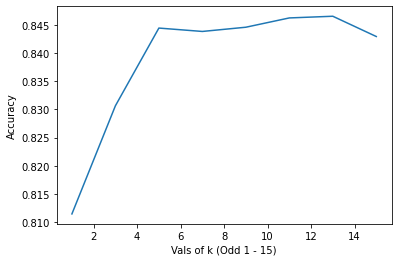

In [10]:
# Train/Predict with normalization using k=1,3,...,15
k_vals = [1, 3, 5, 7, 9, 11, 13, 15]
knn5 = KNNClassifier("categorical", columntype,"no_weight", True)
accuracy_list = predict_with_several_k(k_vals, knn5, X, y, X_test, y_test)
plt.plot(k_vals, accuracy_list)
x_labels = ["1", "3", "5", "7", "9", "11", "13", "15"]
plt.xlabel("Vals of k (Odd 1 - 15)")
plt.ylabel("Accuracy")
plt.show()

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


In [70]:
def mse_several_k(k, knn, X, y, X_test, y_test):
    mse = []
    for k_val in k:
        #print(k, knn, X, y, X_test, y_test)
        knn.fit(X,y,k_val).predict(X_test, y_test)
        print("MSE: ", knn.mse)
        mse.append(knn.mse)

    return mse

In [71]:
# Load housing price prediction data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing-data.arff
train_data = arff.loadarff('housing-data.arff')
df = pd.DataFrame(train_data[0])
# Remove the 'b' 
key = 'CHAS'
df[key] = df[key].str.decode('utf-8')
data = np.array(df)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data[i][j] != type(float):
            data[i][j] = float(data[i][j])
X = data[:,0:-1]
y = data[:,-1]

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing-test-data.arff
test_data = arff.loadarff('housing-test-data.arff')
columntype = test_data[1].types()
columntype = columntype[:-1] # Remove the target columns
df = pd.DataFrame(test_data[0])

# Remove the 'b' 
key = 'CHAS'
df[key] = df[key].str.decode('utf-8')
test_data = np.array(df)

# Turn binary vals into numerical
for i in range(test_data.shape[0]):
    for j in range(test_data.shape[1]):
        if test_data[i][j] != type(float):
            test_data[i][j] = float(test_data[i][j])

for i,lab_type in enumerate(columntype):
    if lab_type == "nominal":
        columntype[i] = "numeric"

X_test = test_data[:,0:-1]
y_test = test_data[:, -1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   513k      0 --:--:-- --:--:-- --:--:--  513k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  74711      0 --:--:-- --:--:-- --:--:-- 74711


MSE:  24.608431372549024
MSE:  16.598692810457518
MSE:  15.89698039215686
MSE:  18.96939575830332
MSE:  20.65886710239651
MSE:  23.49894344514665
MSE:  24.513254437869822
MSE:  24.278203921568632


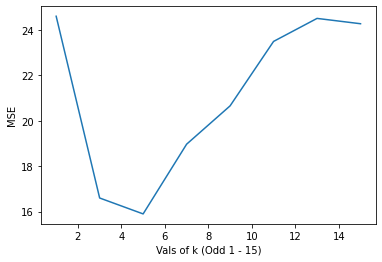

In [73]:
# Train/Predict using k=1,3,...,15
k_vals = [1, 3, 5, 7, 9, 11, 13, 15]
knn6 = KNNClassifier("numeric", columntype, "no_weight", True)

mse_list = mse_several_k(k_vals, knn6, X, y, X_test, y_test)
# Graph MSE over k
plt.plot(k_vals, mse_list)
plt.xlabel("Vals of k (Odd 1 - 15)")
plt.ylabel("MSE")
plt.show()

## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


In [74]:
# Load Magic Telescope data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output telescope-data.arff
train_data = arff.loadarff('telescope-data.arff')
df = pd.DataFrame(train_data[0])
# Remove the 'b' 
key = 'class'
df[key] = df[key].str.decode('utf-8')
data = np.array(df)
X = data[:,0:-1]
y = data[:,-1]

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output telescope-test-data.arff
test_data = arff.loadarff('telescope-test-data.arff')
columntype = test_data[1].types()
columntype = columntype[:-1] # Remove the target columns
df = pd.DataFrame(test_data[0])
# remove the 'b'
df['class'] = df[key].str.decode('utf-8')
test_data = np.array(df)
X_test = test_data[:,0:-1]
y_test = test_data[:, -1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  8371k      0 --:--:-- --:--:-- --:--:-- 8447k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  4515k      0 --:--:-- --:--:-- --:--:-- 4515k


In [38]:
# Without Normalization but with weights
knn7 = KNNClassifier("categorical", columntype,"inverse_distance", False)
knn7.fit(X,y,3).predict(X_test, y_test)
print("Accuracy: ", knn7.accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in double_scalars


Accuracy:  0.8085808580858086


In [39]:
# With Normalization AND with weights

# Train and Predict on training and test set
knn8 = KNNClassifier("categorical", columntype,"inverse_distance", True)
knn8.fit(X,y,3).predict(X_test, y_test)
print("Accuracy: ", knn8.accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in double_scalars


Accuracy:  0.8310831083108311


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in double_scalars


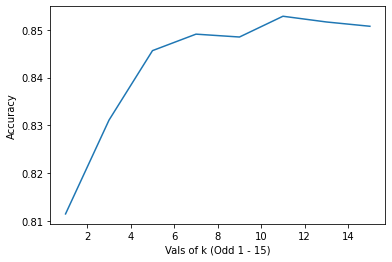

In [40]:
# Train/Predict with normalization using k=1,3,...,15 AND weights
k_vals = [1, 3, 5, 7, 9, 11, 13, 15]
knn9 = KNNClassifier("categorical", columntype,"inverse_distance", True)
accuracy_list = predict_with_several_k(k_vals, knn9, X, y, X_test, y_test)

plt.plot(k_vals, accuracy_list)
plt.xlabel("Vals of k (Odd 1 - 15)")
plt.ylabel("Accuracy")
plt.show()

In [78]:
# Load housing price prediction data using distance-weighted voting
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing-data.arff
train_data = arff.loadarff('housing-data.arff')
df = pd.DataFrame(train_data[0])
# Remove the 'b' 
key = 'CHAS'
df[key] = df[key].str.decode('utf-8')
data = np.array(df)
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         if data[i][j] != type(float):
#             data[i][j] = float(data[i][j])
X = data[:,0:-1]
y = data[:,-1]

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing-test-data.arff
test_data = arff.loadarff('housing-test-data.arff')
columntype = test_data[1].types()
columntype = columntype[:-1] # Remove the target columns
df = pd.DataFrame(test_data[0])

# Remove the 'b' 
key = 'CHAS'
df[key] = df[key].str.decode('utf-8')
test_data = np.array(df)

# for i in range(test_data.shape[0]):
#     for j in range(test_data.shape[1]):
#         if test_data[i][j] != type(float):
#             test_data[i][j] = float(test_data[i][j])

X_test = test_data[:,0:-1]
y_test = test_data[:, -1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   566k      0 --:--:-- --:--:-- --:--:--  575k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  71944      0 --:--:-- --:--:-- --:--:-- 71944


In [47]:
# Without Normalization but with weights
knn10 = KNNClassifier("numeric", columntype,"inverse_distance", False)
knn10.fit(X,y,3).predict(X_test, y_test)
print("MSE: ", knn10.mse)

MSE:  52.46663547423204


In [77]:
# With Normalization AND with weights
knn11 = KNNClassifier("numeric", columntype,"inverse_distance", True)
knn11.fit(X,y,3).predict(X_test, y_test)
print("MSE: ", knn11.mse)

MSE:  16.361204005940902


MSE:  24.608431372549024
MSE:  16.361204005940902
MSE:  12.119627591906248
MSE:  10.736267400258757
MSE:  11.324686866173366
MSE:  11.51191258782557
MSE:  11.605024714527104
MSE:  11.818911599929255


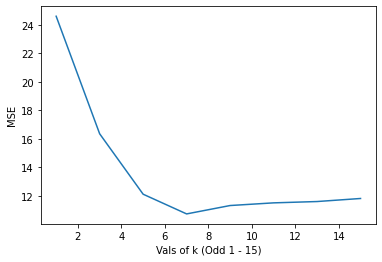

In [79]:
# Train/Predict using k=1,3,...,15
k_vals = [1, 3, 5, 7, 9, 11, 13, 15]
knn12 = KNNClassifier("numeric", columntype, "inverse_distance", True)
mse = mse_several_k(k_vals, knn12, X, y, X_test, y_test)
# Graph MSE over k
plt.plot(k_vals, mse)
plt.xlabel("Vals of k (Odd 1 - 15)")
plt.ylabel("MSE")
plt.show()

When using the wieghting distance with the telesope data it had the exact same accuracy. Theoretically weighted distance will preform better in some situations becuause if a point to predict was on top of a crest with one other point near the top of the mountain, 3 other points in a nearby valley wouldn't have as much effect on the prediction because the nearby point, despite there only being 1 would be weighted heavily. The best model we found had k = 11, inverse distance weighting, and data normalization, with an accuracy of around %85.

With the house data set, the MSE drastically decreased from 52 to 16 simply by normalizing the data. The optimal MSE was found to be 11.3 with parameters k = 7, inverse distance weighting, and data normalization.

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff.txt)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [80]:
def remove_b(keys, df):
    for key in keys:
        df[key] = df[key].str.decode('utf-8')
    return df


HANDLE DISTANCE METRIC WITHOUT IMPUTING VALUES

In [90]:
# Load Credit-approval dataset and split into train/test sets
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff --output credit-approval-data.arff
train_data = arff.loadarff('credit-approval-data.arff')
columntype = train_data[1].types()
columntype = columntype[:-1] # Remove the target columns
df = pd.DataFrame(train_data[0])
# Remove 'b'
keys = ["A1", "A4","A5","A6","A7","A9","A10", "A12", "A13", "class"]
df = remove_b(keys, df)

data = np.array(df)

# Split into training and test set 
X = data[:,0:-1]
y = data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42) 
# Train/Predict credit-approval

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34315  100 34315    0     0   274k      0 --:--:-- --:--:-- --:--:--  274k


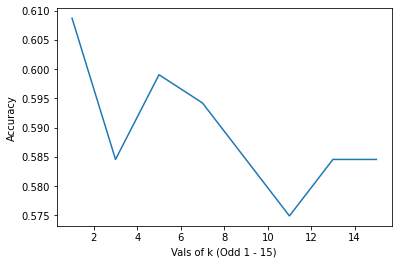

In [96]:
knn14 = KNNClassifier("categorical", columntype,"inverse_distance", False)
accuracy_list = predict_with_several_k(k_vals, knn14, X_train, y_train, X_test, y_test)

plt.plot(k_vals, accuracy_list)
plt.xlabel("Vals of k (Odd 1 - 15)")
plt.ylabel("Accuracy")
plt.show()

In [98]:
# With Normalization AND with weights
knn15 = KNNClassifier("categorical", columntype,"inverse_distance", False)
knn15.fit(X_train,y_train,1).predict(X_test, y_test)
print("Accuracy: ", knn15.accuracy)

Accuracy:  0.6086956521739131


I used the HVDM metric due to the simplicity in the concept. The difficulty with categorical data is the fact that we don't know how close one categorical variable is to another. This metric simply adds a distance of 1 (plus whatever weighted value) if a category of one point does not match the category of another. If they do match, the value is simply 1. In this example, the output label of the prediction was Nominal. When using Nominal data, votes for which category the point should be classified as are calculated by using the distance to weight the amount of a vote. The inverse of distance squared was the metric and that made it so as the distance increased, the vote counted less and less.k As the distance decreased, or as the denominator approached 0, the weight applied to the vote increased.  

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [148]:
def test_ks():
  ks = [1, 3, 5, 7, 9, 11, 13, 15]
  for k in ks:
      knn_SK = KNeighborsClassifier(n_neighbors=k) 
      knn_SK.fit(X, y)
      preds = knn_SK.predict(X_test)
      correct = 0
      total = len(preds)
      for i in range(len(preds)): # For each prediction
          if preds[i] == y_test[i]:
              correct += 1
      print("k =", k," Accuracy: ", correct / total)
      test_metrics(k)

In [135]:
def test_metrics(k):
  ps = [1, 2, 3]
  for p_val in ps:
      knn_SK = KNeighborsClassifier(n_neighbors=k, p = p_val) 
      knn_SK.fit(X, y)
      preds = knn_SK.predict(X_test)
      correct = 0
      total = len(preds)
      for i in range(len(preds)): # For each prediction
          if preds[i] == y_test[i]:
              correct += 1
      if p_val == 1:
          print("Manhatten Distance Accuracy: ", correct / total)
      if p_val == 2:
          print("Euclidean Distance Accuracy: ", correct / total)
      if p_val == 3:
          print("Minkowski Distance Accuracy: ", correct / total, "\n\n")
      

In [149]:
def test_ks_reg():
  ks = [1, 3, 5, 7, 9, 11, 13, 15]
  for k in ks:
      knn_SK = KNeighborsRegressor(n_neighbors=k) 
      knn_SK.fit(X, y)
      score = knn_SK.score(X_test, y_test)
      print("k =", k," R-sqaured: ", score)
      test_metrics_reg(k)

In [137]:
def test_metrics_reg(k):
  ps = [1, 2, 3]
  for p_val in ps:
      knn_SK = KNeighborsRegressor(n_neighbors=k, p = p_val) 
      knn_SK.fit(X, y)
      score = knn_SK.score(X_test, y_test)
      
      if p_val == 1:
          print("Manhatten Distance R-squared: ", score)
      if p_val == 2:
          print("Euclidean Distance R-squared: ", score)
      if p_val == 3:
          print("Minkowski Distance R-squared: ", score, "\n\n")

In [146]:
# Train/Predict magic telescope using scikit's KNN
# Load Magic Telescope data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output telescope-data.arff
train_data = arff.loadarff('telescope-data.arff')
df = pd.DataFrame(train_data[0])
# Remove the 'b' 
key = 'class'
df[key] = df[key].str.decode('utf-8')
data = np.array(df)
X = data[:,0:-1]
y = data[:,-1]

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output telescope-test-data.arff
test_data = arff.loadarff('telescope-test-data.arff')
df = pd.DataFrame(test_data[0])
# remove the 'b'
df['class'] = df[key].str.decode('utf-8')
test_data = np.array(df)
X_test = test_data[:,0:-1]
y_test = test_data[:, -1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  3135k      0 --:--:-- --:--:-- --:--:-- 3135k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  2385k      0 --:--:-- --:--:-- --:--:-- 2385k


In [150]:
print("Telescope data with SKLearn Classifier\n")
print(" Testing different metrics with different values of K ")
#print(" Defaults(Minkowski metric, weighting: uniform)")
test_ks()
#print(" Testing different metrics")
#print(" Defaults(k = 5, weighting: uniform)")

Telescope data with SKLearn Classifier

 Testing different metrics with different values of K 
k = 1  Accuracy:  0.7856285628562857
Manhatten Distance Accuracy:  0.7913291329132913
Euclidean Distance Accuracy:  0.7856285628562857
Minkowski Distance Accuracy:  0.7835283528352835 


k = 3  Accuracy:  0.8082808280828083
Manhatten Distance Accuracy:  0.8093309330933093
Euclidean Distance Accuracy:  0.8082808280828083
Minkowski Distance Accuracy:  0.8052805280528053 


k = 5  Accuracy:  0.8136813681368137
Manhatten Distance Accuracy:  0.8178817881788178
Euclidean Distance Accuracy:  0.8136813681368137
Minkowski Distance Accuracy:  0.8120312031203121 


k = 7  Accuracy:  0.8156315631563157
Manhatten Distance Accuracy:  0.8198319831983198
Euclidean Distance Accuracy:  0.8156315631563157
Minkowski Distance Accuracy:  0.8121812181218122 


k = 9  Accuracy:  0.8181818181818182
Manhatten Distance Accuracy:  0.8204320432043204
Euclidean Distance Accuracy:  0.8181818181818182
Minkowski Distance Acc

In [151]:
# Load housing price prediction data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing-data.arff
train_data = arff.loadarff('housing-data.arff')
df = pd.DataFrame(train_data[0])
data = np.array(df)
X = data[:,0:-1]
y = data[:,-1]

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing-test-data.arff
test_data = arff.loadarff('housing-test-data.arff')
df = pd.DataFrame(test_data[0])
test_data = np.array(df)
X_test = test_data[:,0:-1]
y_test = test_data[:, -1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   392k      0 --:--:-- --:--:-- --:--:--  392k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  26428      0 --:--:-- --:--:-- --:--:-- 26609


In [153]:
# Train/Predict housing using scikit's KNN
print("House data with SKLearn Regressor\n")
print(" Testing different metrics with different values of K, Default: Euclidean ")
test_ks_reg()


House data with SKLearn Regressor

 Testing different metrics with different values of K, Default: Euclidean 
k = 1  R-sqaured:  0.20057879812377452
Manhatten Distance R-squared:  0.33668750770665645
Euclidean Distance R-squared:  0.20057879812377452
Minkowski Distance R-squared:  0.15426090191534425 


k = 3  R-sqaured:  0.3089347485187751
Manhatten Distance R-squared:  0.5239194218245957
Euclidean Distance R-squared:  0.3089347485187751
Minkowski Distance R-squared:  0.22292245846883407 


k = 5  R-sqaured:  0.25491902354492035
Manhatten Distance R-squared:  0.5019074141723017
Euclidean Distance R-squared:  0.25491902354492035
Minkowski Distance R-squared:  0.17347095770627008 


k = 7  R-sqaured:  0.2979443003218095
Manhatten Distance R-squared:  0.5854929026153172
Euclidean Distance R-squared:  0.2979443003218095
Minkowski Distance R-squared:  0.22878778243746356 


k = 9  R-sqaured:  0.3304110364341829
Manhatten Distance R-squared:  0.5345249535997172
Euclidean Distance R-squared:

Note* All of the models utilized normalized values

Observations of the Telescope Data set:

The optimal model had an accuracy of %82.07 with the parameters k=15, and the  Euclidean distance metric. On average the Euclidean distance preformed better than the Manhatten and the Minkowski in this order. As k increased, so did accuracy, until it tapered off at 82%. To calculate all different iterations took around 10 seconds.

Observations of the Housing Data set:

The optimal model had an MSE of .58 with the parameters k=7, and the Manhatten distance. The Manhatten distance preformed best by a large margin followed by the Euclidean distance metric, followed by a poor preforming Minkowski Distance. The model took less than a second to calculate all iterations and was much better than the Nominal KNN classifier in terms of speed. Overal our best model had an okay r-sqared, showing us that our data was able to explain %58 of the variation in predicted results. This tells us that our model predicts from the data well.

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
